# RoBERTa-LSTM model for sentiment analysis

In [2]:
!pip install transformers loguru datasets peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger
from tqdm import trange
import pickle
from IPython.display import clear_output

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import tokenizers
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import time

In [5]:
from google.colab import drive
from tqdm.notebook import tqdm
from tqdm import trange


drive.mount("/drive")

Mounted at /drive


# Data preparation and vectorization

In [6]:
path = "/drive/My Drive/Colab Notebooks/sentiment analysis/IMDB Dataset.csv"

data = pd.read_csv(path)
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## Encode sentiment feature with 0 and 1

In [7]:
data['num_sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
data

,review,sentiment,num_sentiment
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1
...,...,...,...
49995,I thought this movie did a down right good job...,positive,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0
49997,I am a Catholic taught in parochial elementary...,negative,0
49998,I'm going to have to disagree with the previou...,negative,0


### Dataset is balanced so oversampling or downsampling techniques aren't necessary

In [ ]:
data['num_sentiment'].value_counts()

1    25000
0    25000
Name: num_sentiment, dtype: int64

### Loading baseline models for generating embedding representation

In [ ]:
roberta_model = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Example of review text, it's not clear and several preprocessing techniques will be applied

- Tokenezation
- Appling stemming to tokenized data
- Removing stop words and most common words
- Removing HTML tags and other junk data
- Creating embedding representation

In [ ]:
review_data = data['review'].tolist()
review_data[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

### Lowering

In [8]:
data['review'] = data['review'].str.lower()

### Removing HTML tags

In [10]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(f'',text)

In [11]:
data['review'] = data['review'].apply(remove_html_tags)
data['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

### Cleaning pipeline

In [12]:
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    # Tokenize the text
    words = nltk.word_tokenize(text)
    # Remove stopwords
    words = [w for w in words if w not in stopwords.words('english')]
    # Stem the words
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words]
    # Join the words back into a string
    text = ' '.join(words)
    return text

In [ ]:
data['review'] = data['review'].progress_apply(clean_text)

### Encoding text to vector embeddings

In [ ]:
encoded_inputs = tokenizer(review_data, padding=True, truncation=True, return_tensors='pt')
encoded_inputs

{'input_ids': tensor([[   0, 3762,    9,  ...,    1,    1,    1],
        [   0,  250, 4613,  ...,    1,    1,    1],
        [   0,  100,  802,  ...,    1,    1,    1],
        ...,
        [   0,  100,  524,  ...,    1,    1,    1],
        [   0,  100,  437,  ...,    1,    1,    1],
        [   0, 3084,   65,  ...,    1,    1,    1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
encoded_inputs['attention_mask'].shape

torch.Size([50000, 512])

### Example of output of base model, these data will be used for LSTM module

In [ ]:
out = model(encoded_inputs['input_ids'][0:2], attention_mask=encoded_inputs['attention_mask'][0:2])
out

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.0510,  0.0597, -0.0011,  ..., -0.0933,  0.0020, -0.0234],
         [-0.1599,  0.1393,  0.1117,  ..., -0.0091, -0.0834,  0.3128],
         [ 0.0560,  0.1997,  0.0652,  ..., -0.0647,  0.0694,  0.3582],
         ...,
         [-0.0523,  0.0640,  0.0309,  ..., -0.0750,  0.0560,  0.0862],
         [-0.0523,  0.0640,  0.0309,  ..., -0.0750,  0.0560,  0.0862],
         [-0.0523,  0.0640,  0.0309,  ..., -0.0750,  0.0560,  0.0862]],

        [[-0.0706,  0.0689,  0.0088,  ..., -0.1082, -0.0283, -0.0280],
         [-0.1744,  0.1866,  0.1022,  ...,  0.2073,  0.0831,  0.1631],
         [ 0.0475,  0.6007,  0.2569,  ...,  0.7535,  0.2661, -0.0825],
         ...,
         [ 0.0028,  0.0085,  0.0527,  ..., -0.0068,  0.0331, -0.0192],
         [ 0.0028,  0.0085,  0.0527,  ..., -0.0068,  0.0331, -0.0192],
         [ 0.0028,  0.0085,  0.0527,  ..., -0.0068,  0.0331, -0.0192]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_ou

In [ ]:
out.last_hidden_state.shape

torch.Size([2, 512, 768])

## Preparing data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
class CleanData(Dataset):

  def __tokenize(self):
    review_data = self.X.tolist()
    logger.info("strart tokenizing")
    return self.tokenizer(review_data, padding=True, truncation=True, return_tensors='pt')

  def __init__(self, data: pd.DataFrame, tokenizer) -> None:
    self.X = data['review'].iloc[:500]
    self.y = torch.tensor(data['num_sentiment'].iloc[:500])
    self.tokenizer = tokenizer
    self.tokens = self.__tokenize()

  def __len__(self) -> int:
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.tokens.input_ids[idx], self.tokens.attention_mask[idx], self.y[idx]

In [ ]:
clear_data = CleanData(data, tokenizer)

2023-04-21 16:39:05.755 | INFO     | __main__:__tokenize:5 - strart tokenizing


In [ ]:
batch_size = 16
train_dataloader = DataLoader(clear_data, batch_size=batch_size, shuffle=True)

### Modeling

In [ ]:
class RoBERTaLSTM(nn.Module):

  def __init__(self,
               roberta_model,
               input_size: int,
               hidden_size: int,
               lstm_layers: int,
               dropout: float,
               output_size: int
               ) -> None:
    super(RoBERTaLSTM, self).__init__()
    self.roberta_model = roberta_model
    self.hidden_size = hidden_size
    self.lstm_layers = lstm_layers

    self.lstm_block = nn.LSTM(input_size, hidden_size, lstm_layers, batch_first=True)
    self.drop_out_block = nn.Dropout(dropout)
    self.linear_block = nn.Linear(hidden_size, output_size)
    self.softmax = nn.Sigmoid()

  def forward(self, x, att):
    embedded_x = self.roberta_model(x, attention_mask=att)

    h_0 = embedded_x.last_hidden_state[:, -1, :].contiguous().to(device)
    c_0 = embedded_x.last_hidden_state[:, -1, :].contiguous().to(device)
    lstm_out, _ = self.lstm_block(embedded_x.pooler_output, (h_0, c_0))
    dropped_out = self.drop_out_block(lstm_out)
    out = self.softmax(self.linear_block(dropped_out))
    return out

In [ ]:
model = RoBERTaLSTM(roberta_model, 768, 768, 256, 0.5, 1)
model.to(device)
print(model)

RoBERTaLSTM(
  (roberta_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

## Training

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Training logs
interval = 10
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [ ]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 

In [ ]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (_, X, att, y) in enumerate(dataloader):
        # Send data to training device
        X, att, y = X.to(device), att.to(device), y.to(device)
        # Compute prediction error
        pred = model(X, att)
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Progress output
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [ ]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for _, X, att, y in dataloader:
            X, att, y = X.to(device), att.to(device), y.to(device)
            pred = model(X, att)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

In [ ]:
train(10, dataloader, model, loss_fn, optimizer)

  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.000169
2,0.009100,0.000073
3,0.009100,0.000058


{'eval_loss': 5.846978092449717e-05,
 'eval_runtime': 65.906,
 'eval_samples_per_second': 30.346,
 'eval_steps_per_second': 1.897,
 'epoch': 3.0}

### Result are simmilar to author's one in a paper

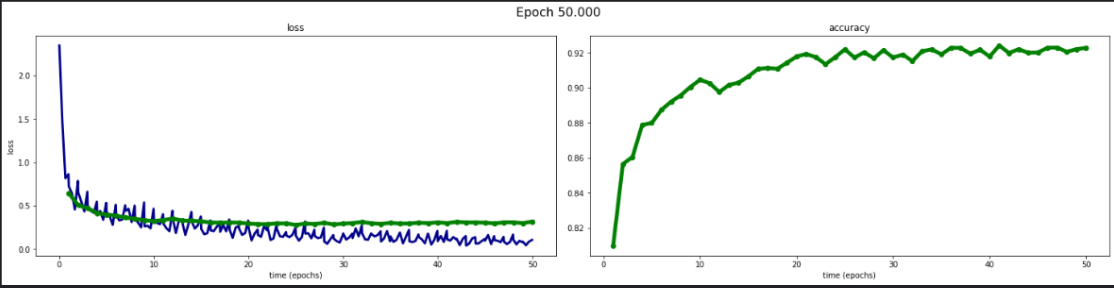